In [1]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

Opening and lazy loading netCDF files
Loading dataset into memory
Converting xarray Dataset to Pytorch tensor

##########################################
############ PROCESSING DONE #############
##########################################

Opening and lazy loading netCDF files
Loading dataset into memory
Converting xarray Dataset to Pytorch tensor

##########################################
############ PROCESSING DONE #############
##########################################

Opening and lazy loading netCDF files
Loading dataset into memory
Converting xarray Dataset to Pytorch tensor

##########################################
############ PROCESSING DONE #############
##########################################



Train :: Epoch: 1/2:   0%|                                                                                                                                          | 1/4563 [00:00<14:32,  5.23it/s]

Computing statistics for standardization


:: Evaluation :::   1%|▊                                                                                                                                             | 5/913 [00:00<00:20, 43.69it/s]

Computing statistics for standardization


:: Evaluation ::: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 913/913 [00:18<00:00, 50.51it/s, Loss: 3187.3738]


Computing statistics for standardization


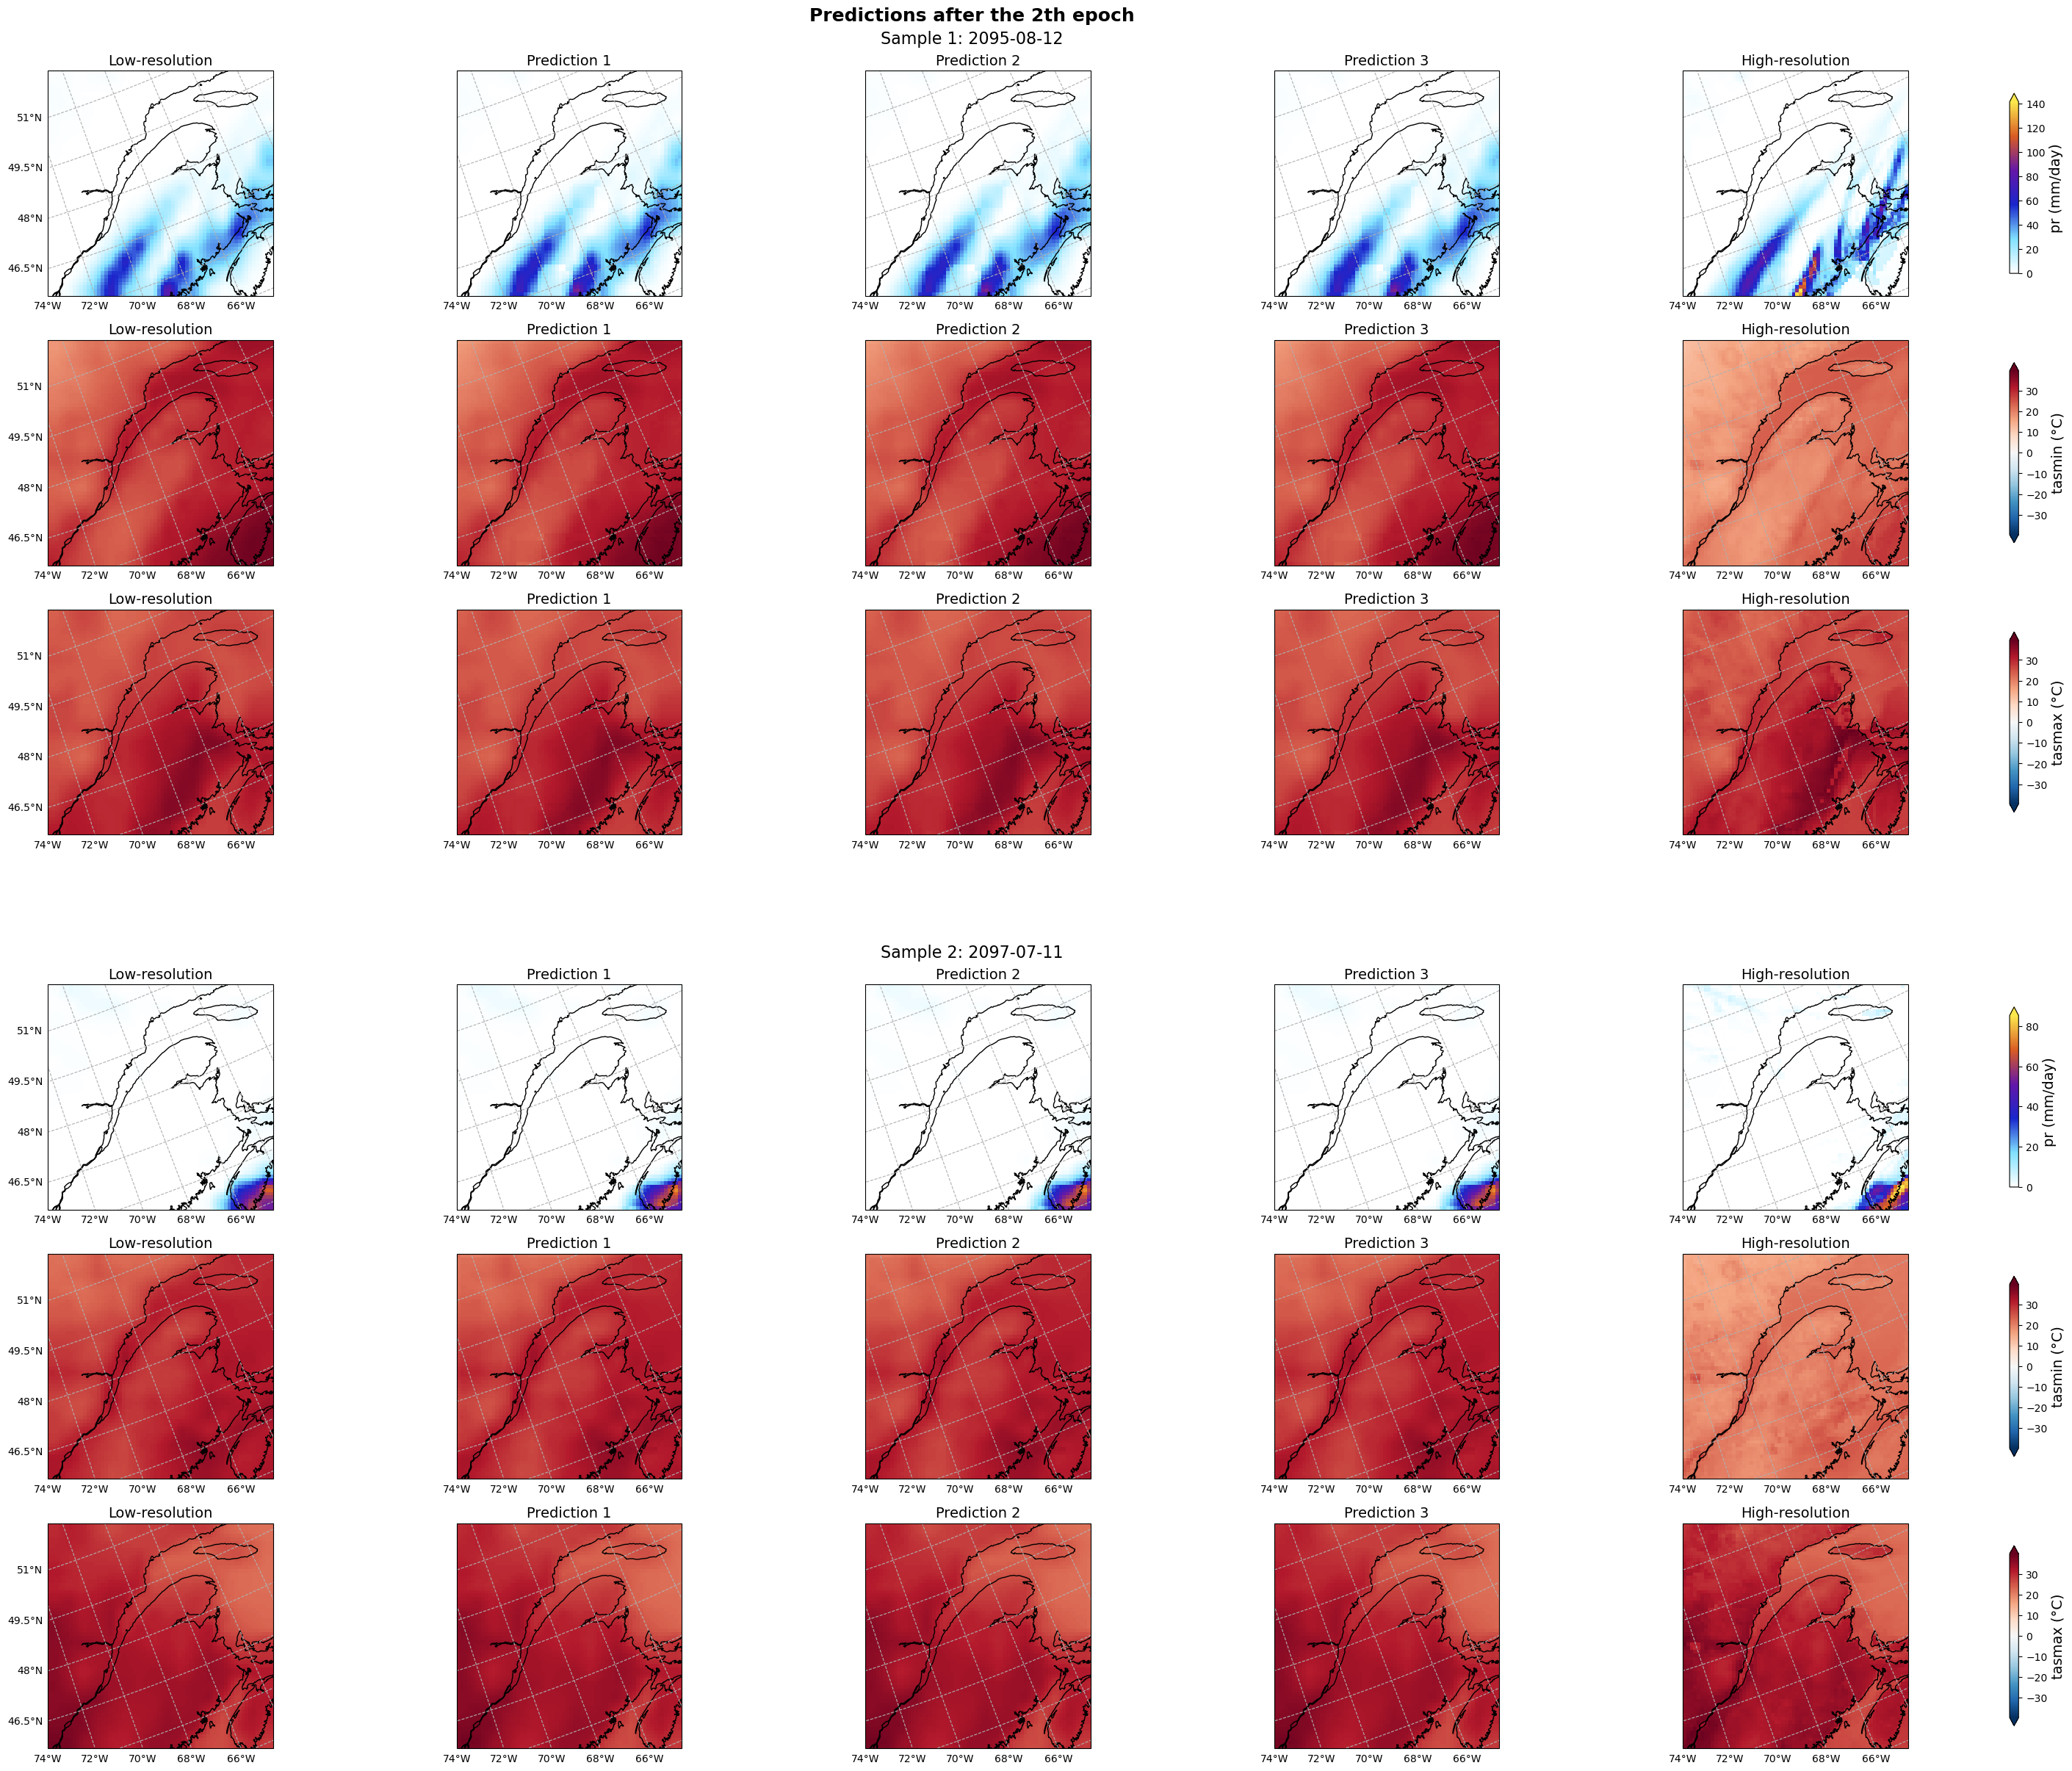

In [2]:
import torch
import matplotlib.pyplot as plt
from dask.distributed import Client

import climex_utils as cu
import train_prob_unet_model as tm  
from prob_unet import ProbabilisticUNet

if __name__ == "__main__":

    # Initialize Dask Client once
    client = Client()

    # Importing all required arguments
    args = tm.get_args()

    # Adjust arguments for testing
    args.years_train = range(1960, 2060)
    args.years_val = range(2060, 2080)
    args.years_test = range(2080, 2098)
    args.coords = [120, 184, 120, 184]
    args.resolution = (64, 64)
    args.standardization = "perpixel"
    args.variables = ['pr', 'tasmin', 'tasmax']
    args.num_epochs = 2
    args.batch_size = 8
    args.beta = 0.01
    args.wandb = False


    # Initializing the Probabilistic UNet model
    probunet_model = ProbabilisticUNet(
        input_channels=len(args.variables),
        num_classes=len(args.variables),
        latent_dim=6,
        num_filters=[64, 128, 256, 512]
    ).to(args.device)

    # Initializing the datasets
    dataset_train = cu.climex2torch(
        datadir=args.datadir,
        years=args.years_train,
        variables=args.variables,
        coords=args.coords,
        lowres_scale=args.lowres_scale,
        standardization=args.standardization,
        client=client
    )
    dataset_val = cu.climex2torch(
        datadir=args.datadir,
        years=args.years_val,
        variables=args.variables,
        coords=args.coords,
        lowres_scale=args.lowres_scale,
        standardization=args.standardization,
        client=client
    )
    dataset_test = cu.climex2torch(
        datadir=args.datadir,
        years=args.years_test,
        variables=args.variables,
        coords=args.coords,
        lowres_scale=args.lowres_scale,
        standardization=args.standardization,
        client=client
    )

    # Initializing the dataloaders
    dataloader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=0
    )
    dataloader_val = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=0
    )
    dataloader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=0
    )
    dataloader_test_random = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=2,
        shuffle=True,
        num_workers=0
    )

    # Initializing training objects
    optimizer = args.optimizer(params=probunet_model.parameters(), lr=args.lr)

    tr_losses = []
    val_losses = []

    # Training loop
    for epoch in range(1, args.num_epochs + 1):
        # Training for one epoch
        epoch_tr_loss = tm.train_probunet_step(
            model=probunet_model,
            dataloader=dataloader_train,
            optimizer=optimizer,
            epoch=epoch,
            num_epochs=args.num_epochs,
            accum=args.accum,
            wandb_active=args.wandb,
            device=args.device
        )
        tr_losses.append(epoch_tr_loss)

        # Evaluating the model on validation data
        epoch_val_loss = tm.eval_probunet_model(
            model=probunet_model,
            dataloader=dataloader_val,
            wandb_active=args.wandb,
            device=args.device
        )
        val_losses.append(epoch_val_loss)

        # Sampling from the model every 2 epochs
        if epoch % 2 == 0:
            samples, (fig, axs) = tm.sample_probunet_model(
                model=probunet_model,
                dataloader=dataloader_test_random,
                epoch=epoch,
                device=args.device
            )
            # Save sample plots
            fig.savefig(f"{args.plotdir}/epoch{epoch}.png", dpi=300)
            plt.close(fig)

    # Plotting the training and validation losses
    fig = plt.figure(figsize=(15, 10))
    plt.plot(tr_losses, lw=2, label='Training Loss')
    plt.plot(val_losses, lw=2, linestyle='dashed', label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    fig.savefig(f"{args.plotdir}/loss.png", dpi=300)
    plt.close(fig)


    # Close the Dask Client after training is complete
    client.close()